### erddapy example for PMEL tools - Drifters and Alamo Floats (2018)

__pyversion__==3.6   
__author__==S.Bell

### connecting and basic information

In [44]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [45]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='alamo'))
df_d = pd.read_csv(e.get_search_url(response='csv', search_for='drifter'))

In [46]:
argos = df['Dataset ID'].values
print(argos)

['arctic_heat_alamo_profiles_9058' 'arctic_heat_alamo_profiles_9076'
 'arctic_heat_alamo_profiles_9085' 'arctic_heat_alamo_profiles_9115'
 'arctic_heat_alamo_profiles_9116' 'arctic_heat_alamo_profiles_9117'
 'arctic_heat_alamo_profiles_9119' 'arctic_heat_alamo_profiles_9150'
 'arctic_heat_alamo_profiles_9152' 'arctic_heat_alamo_profiles_9153']


In [47]:
drifter = df_d['Dataset ID'].values
print(drifter)

['2015_Argos_Drifters' '2016_Argos_Drifters' '2017_Argos_Drifters'
 '2018_Argos_Drifters']


In [48]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -360,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z'
}

In [49]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]
variables_2 = [e.get_var_by_attr(dataset_id=drifterid, long_name=lambda v: v is not None) for drifterid in drifter]

In [50]:
common_variables = set(variables[0]).intersection(*variables[1:])
common_variables_2 = set(variables_2[0]).intersection(*variables_2[1:])

common_variables.update(['profileid']) 
common_variables_2.update(['trajectory_id']) 
common_variables

{'CYCLE_NUMBER',
 'FLOAT_SERIAL_NO',
 'PRES',
 'REFERENCE_DATE_TIME',
 'TEMP',
 'latitude',
 'longitude',
 'profileid',
 'time'}

In [51]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)



http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_9058.csv?latitude,longitude,PRES,CYCLE_NUMBER,FLOAT_SERIAL_NO,time,profileid,TEMP,REFERENCE_DATE_TIME&longitude>=-360&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


In [52]:
from requests.exceptions import HTTPError

dfs = {}
for arfloat in argos:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({arfloat: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153


In [53]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

try:
    download_url = e.get_download_url(
        protocol='tabledap',
        response='csv',
    )
    e.variables=common_variables_2,
    e.constraints=constraints
    e.dataset_id=drifter[0],

    print(download_url)
except HTTPError:
    print("Failed to Download from URL")


http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_9153.csv?latitude,longitude,PRES,CYCLE_NUMBER,FLOAT_SERIAL_NO,time,profileid,TEMP,REFERENCE_DATE_TIME&longitude>=-360&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


In [54]:
from requests.exceptions import HTTPError

dfs_2 = {}
for arfloat in drifter:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables_2
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs_2.update({arfloat: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

2015_Argos_Drifters
2016_Argos_Drifters
2017_Argos_Drifters
2018_Argos_Drifters


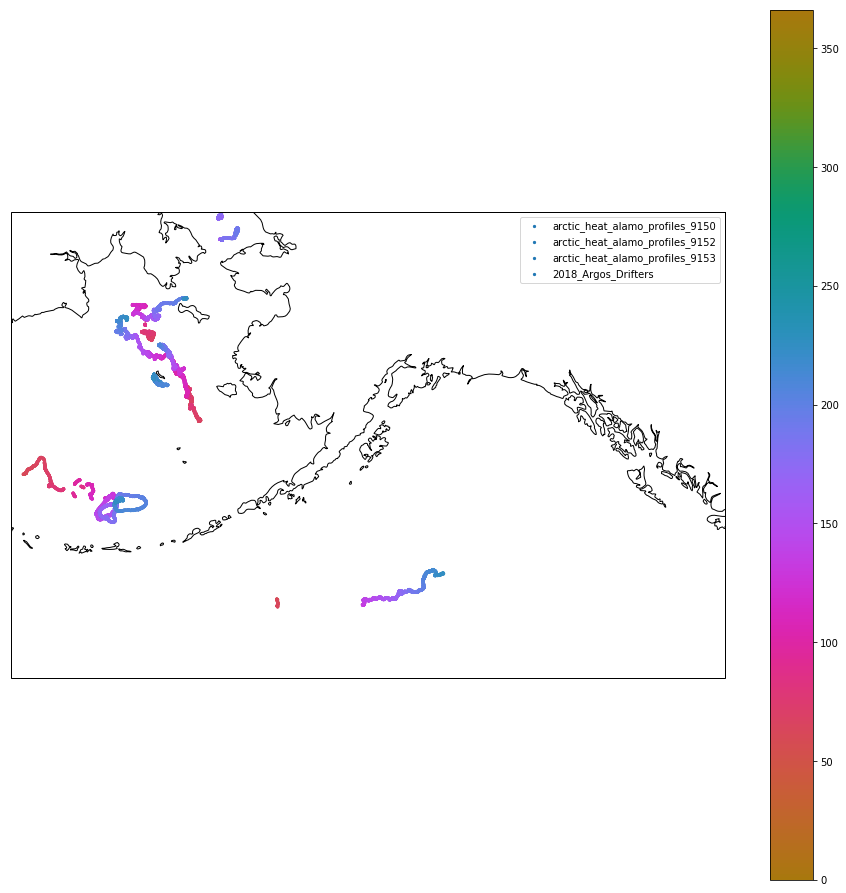

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 16),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax, plt

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 45, 66]
fig,ax,plt = make_map(projection=projection)
for alamo, df in dfs.items():
    #ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.index.dayofyear, cmap=cmocean.cm.phase, vmin=0, vmax=366, label=alamo, transform=transformation)
   
for alamo, df in dfs_2.items():
    #ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.index.dayofyear, cmap=cmocean.cm.phase, vmin=0, vmax=366, label=alamo, transform=transformation)
   
plt.colorbar(t)
leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

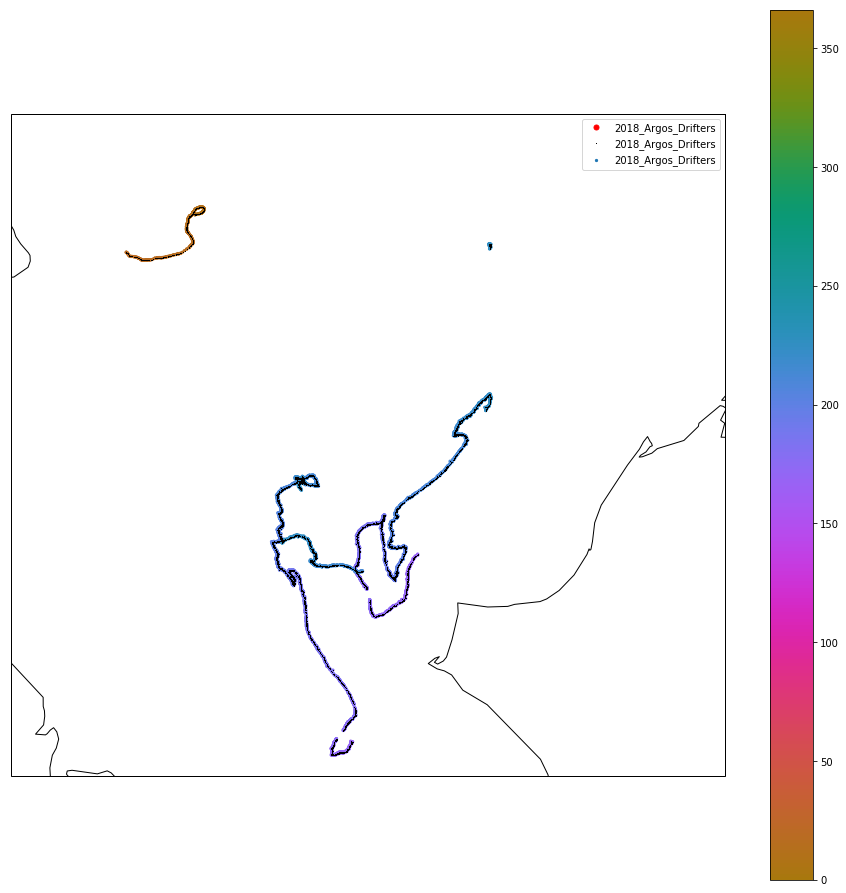

In [56]:

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -160, 67.5, 72.5]

fig,ax,plt = make_map(projection=projection)

'''
for alamo, df in dfs.items():
    ax.plot(df['longitude'][0], df['latitude'][0], 'or', markersize=5., label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=0.5, label=alamo, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.index.dayofyear, cmap=cmocean.cm.phase, vmin=0, vmax=366, label=alamo, transform=transformation)
'''

for alamo, df in dfs_2.items():
    ax.plot(df['longitude'][0], df['latitude'][0], 'or', markersize=5., label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=0.5, label=alamo, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.index.dayofyear, cmap=cmocean.cm.phase, vmin=0, vmax=366, label=alamo, transform=transformation)

plt.colorbar(t)
leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

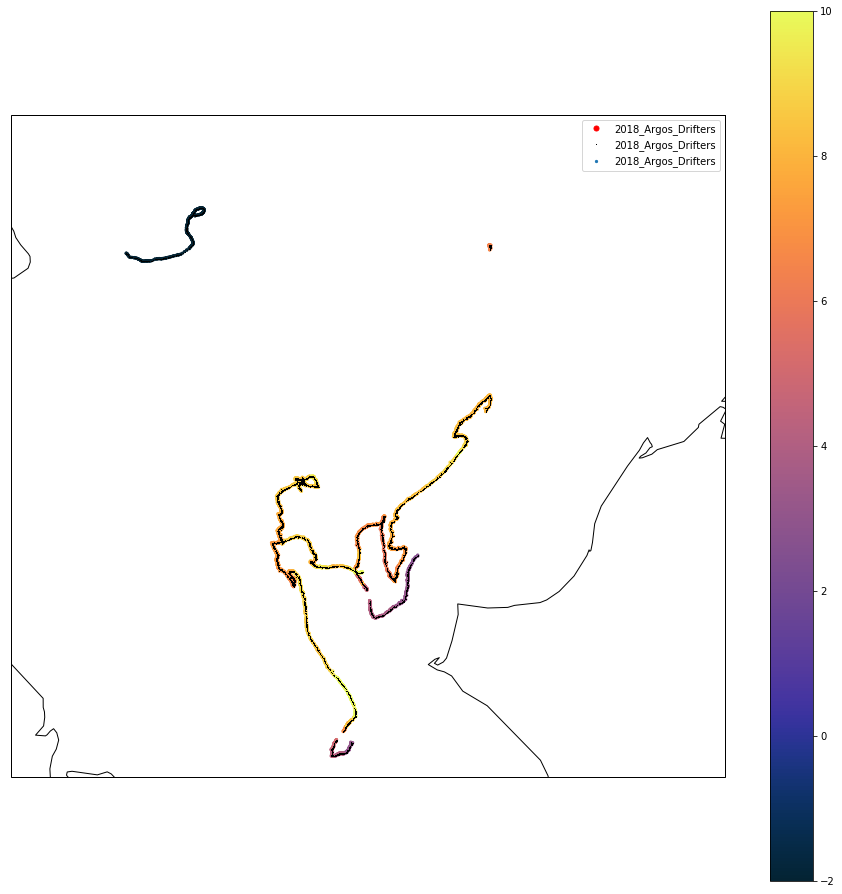

In [57]:
projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -160, 67.5, 72.5]

fig,ax,plt = make_map(projection=projection)

for alamo, df in dfs_2.items():
    ax.plot(df['longitude'][0], df['latitude'][0], 'or', markersize=5., label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=0.5, label=alamo, transform=transformation)
    t = ax.scatter(df['longitude'], df['latitude'], s=5,c=df.sst, cmap=cmocean.cm.thermal, vmin=-2, vmax=10, label=alamo, transform=transformation)

plt.colorbar(t)
leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [58]:
df.tail()

,latitude,longitude,strain,voltage,trajectory_id,sst
time,,,,,,
2018-08-13 21:05:00,54.36253,185.18174,0.0,10.4,148276,9.48
2018-08-13 21:29:00,54.35149,185.19054,0.0,10.4,148276,9.48
2018-08-13 21:52:00,54.35247,185.18746,0.0,10.4,148276,9.48
2018-08-13 22:50:00,54.34608,185.22473,0.0,10.4,148276,9.52
2018-08-13 23:27:00,54.34009,185.21236,0.0,10.4,148276,9.56


In [59]:
t=df.groupby('trajectory_id')
t.groups.keys()

dict_keys([136863, 136866, 136867, 136868, 136869, 139910, 139911, 139912, 139913, 145469, 145473, 145474, 145480, 148276])

# Using Python-GMT

In [60]:
import gmt

ModuleNotFoundError: No module named 'gmt'

In [ ]:
fig = gmt.Figure()

fig.coast(region=[-175, -160, 65, 75], projection='B-167.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [ ]:
dfg = dfs_2['2018_Argos_Drifters'].groupby('trajectory_id')
dfg.groups.keys()

In [ ]:
#color by id for one year
clist=['red','black','blue','green','cyan','yellow','orange','lightred','lightgray',
      'lightblue','lightgreen','lightyellow','brown','darkgray']
count=0
for traj in dfg.groups.keys():
    fig.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

In [ ]:
fig.show()

In [ ]:
fig1 = gmt.Figure()

fig1.coast(region=[-175, -160, 65, 75], projection='B-167.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [ ]:
#color by sst
for ship, df in dfs_2.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


## GMT - SST

In [ ]:
fig1.show()

## GMT - DOY

In [ ]:
#color by doy and save each days image to make a move - 7 days of data max (so its a worm)
for ship, df in dfs_2.items():
    
    #choose temp boundaries
    for dstep in range(0,65):
        
        fig1 = gmt.Figure()

        fig1.coast(region=[-175, -160, 65, 75], projection='B-167.5/60/55/60/6i', land='lightgray', water='gray',
              frame=True,U=True)

        stopdate=datetime.datetime.strftime(datetime.datetime(2018,6,1)+datetime.timedelta(days=dstep),'%Y-%m-%d')
        startdate=datetime.datetime.strftime(datetime.datetime(2018,6,1)+datetime.timedelta(days=dstep)-datetime.timedelta(days=7),'%Y-%m-%d')
        dfmiss = df[startdate:stopdate].copy()
        dfmiss['dayofyear'] = dfmiss.index.dayofyear
        #dfmiss.dayofyear.loc[(df.dayofyear > 0) | (df.dayofyear < 366)] = np.nan
        # normalize data for colormap
        dfnorm = dfmiss.apply(lambda x: (x - (0)) / (366 - (0)))
        fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.dayofyear, cmap='phase', style='c0.05c')

        '''for ship, df in dfs.items():
            #choose temp boundaries
            dfmiss = df.copy()
            dfmiss['dayofyear'] = dfmiss.index.dayofyear
            #dfmiss.dayofyear.loc[(df.dayofyear > 0) | (df.dayofyear < 366)] = np.nan
            # normalize data for colormap
            dfnorm = dfmiss['dayofyear'].apply(lambda x: (x - (0)) / (366 - (0)))
            fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm, cmap='phase', style='c0.05c')
        '''
        fig1.savefig(stopdate + '.png')